## Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые перешли на новые тарифы тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Считаем, что предобработка данных уже проведена

Задача:  
Постройте модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.io as pio
import plotly.graph_objs as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from tqdm import tqdm
from time import sleep

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## Разбиение данные на выборки

**features - признаки  
target - целевой признак**

In [5]:
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

In [6]:
print(math.floor(target.loc[target == 1].count() / 3214 * 100), '%')

30 %


**30% данных в таргете - единицы  
70% - нули**

**Так как нужно поделить df на три части: тестовую, валидационную и обучающую, применим метод train_test_split два раза и поделим в соотношении 1:1:3 (тестовую выборку нам не предоставили)**

In [7]:
features_1, features_valid, target_1, target_valid = train_test_split(
    features, target, test_size = 0.20, random_state=12345, stratify = target)

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
    features_1, target_1, test_size = 0.25, random_state=12345, stratify = target_1)

In [9]:
# Проверим размеры
display(features_train.shape)
display(features_test.shape)
display(features_valid.shape)

display(target_train.shape)
display(target_test.shape)
display(target_valid.shape)

(1928, 4)

(643, 4)

(643, 4)

(1928,)

(643,)

(643,)

## Исследование моделей

### Decision Tree

**В цикле пройдемся по значениям возможной глубины дерева, чтобы оценить, какая высота дерева позволит получить лучшее значение accuracy на валидационной выборке**

In [10]:
tree_model = None
best_result = 0
res_valid_tree = []
res_train_tree = []

for depth in tqdm(range(1, 18), desc = 'models', unit = ' models'): 
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth) 
    
    # Обучение модели на обучающей выборке
    model.fit(features_train, target_train)
    
    # Предсказание модели на валидационной выборке
    predictions_valid = model.predict(features_valid)
    
    # Расчет accuracy валидационной выборки 
    result_valid = accuracy_score(target_valid, predictions_valid) 
    res_valid_tree.append(result_valid)
    
    # Предсказание модели на тренировочной выборке
    predictions_train = model.predict(features_train)
    
    # Расчет accuracy тренировочной выборки 
    result_train = accuracy_score(target_train, predictions_train) 
    res_train_tree.append(result_train)
    
    
    #print("max_depth =", depth, ": ", end='')
    #print(result_valid)
    
    # Выбор лучшей модели
    if result_valid > best_result:
        tree_model = model
        best_result = result_valid
        best_depth = depth
    
print('\n')        
print('Глубина лучшей модели:', best_depth)
print('Accuracy лучшей модели:', best_result)

models: 100%|██████████| 17/17 [00:00<00:00, 92.33 models/s] 



Глубина лучшей модели: 3
Accuracy лучшей модели: 0.7993779160186625


Визуализируем значение accuracy в зависимости от глубины дерева

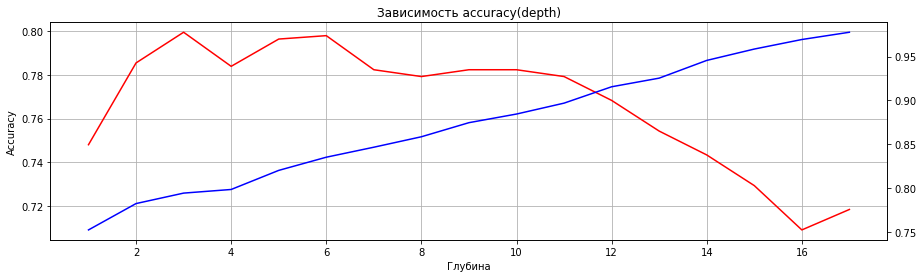

In [11]:
x = [x for x in range(1,18)]               
y = res_valid_tree
y2 = res_train_tree

fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(x, y, 'r')
ax1.grid(True)
ax1.set_xlabel('Глубина')
ax1.set_ylabel('Accuracy')

ax2.plot(x,y2, 'b')
ax2.set_title('Зависимость accuracy(depth)');

**Accuracy тренировочной выборки постоянно растет и с увеличением глубины будет стремиться к единице, но это не гарантирует высоких значений accuracy для валидационной и тестовой выборок. Высокое значение глубины ухудшает долю правильных ответов модели, так как на некоторые уровни попадает недостаточное количество значений для корректного прогноза. Лучше всего результат показала модель с высотой дерева, равной 3 (79.93%)**

### Random Forest

In [12]:
forest_model = None
best_result = 0
res_valid_forest = []
res_train_forest = []
for est in tqdm(range(1, 20), desc = '1st loop'):
    for depth in (range(1, 20)):
    
        # объявление модели с количеством деревьев, равным est
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
    
        # обучение модели на тренировочной выборке
        model.fit(features_train, target_train)
    
        # Предсказание модели на валидационной выборке
        predictions_valid = model.predict(features_valid) 
    
        # Расчет accuracy валидационной выборки 
        result_valid = accuracy_score(target_valid, predictions_valid) 
        if est == 18:
            res_valid_forest.append(result_valid)
    
        # Предсказание модели на тренировочной выборке
        predictions_train = model.predict(features_train)
    
        # Расчет accuracy тренировочной выборки 
        result_train = accuracy_score(target_train, predictions_train) 
        if est == 18:
            res_train_forest.append(result_train)
    
        #print("Количество деревьев =", est, ": ", 'Глубина = ', depth, 'Accuracy = ', result_valid)
    
        if result_valid > best_result:
            forest_model = model
            best_result = result_valid
            best_est = est
            best_depth = depth
        sleep(0.1)
        
print('\n')
print("Количество деревьев:", best_est)        
print("Глубина:", best_depth)
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

1st loop: 100%|██████████| 19/19 [00:55<00:00,  2.95s/it]



Количество деревьев: 18
Глубина: 17
Accuracy наилучшей модели на валидационной выборке: 0.8195956454121306


**Построим график при количестве деревьев, равном восемнадцати, так как за accuracy отвечают два параметра. Это число было выбрано для того, чтобы на графике был виден лучший результат модели**

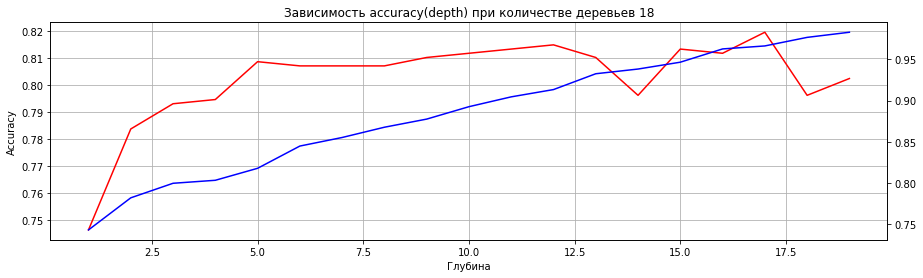

In [13]:
x = [x for x in range(1,20)]               
y = res_valid_forest
y2 = res_train_forest

fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(x, y, 'r')
ax1.grid(True)
ax1.set_xlabel('Глубина')
ax1.set_ylabel('Accuracy')

ax2.plot(x, y2, 'b')
ax2.set_title('Зависимость accuracy(depth) при количестве деревьев 18');

**Согласно расчетам, количество деревьев = 18 и глубина = 17 показывает наилучший результат accuracy (81.95%)**

### Логистическая регрессия

In [14]:
model = LogisticRegression(random_state = 12345, solver = 'lbfgs', max_iter = 100)

# Обучение моедли на тренировочной выборке
model.fit(features_train, target_train)

# Предсказание модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# Расчет accuracy валидационной выборки 
result_valid = accuracy_score(target_valid, predictions_valid)

print("Accuracy модели на валидационной выборке:", result_valid)

Accuracy модели на валидационной выборке: 0.7371695178849145


## Проверка модели на тестовой выборке

**Проверка модели случайного леса**

**Для проверки возьмем лучшую модель с глубиной 17 и 18-ю деревьями**

In [15]:
# Предсказание модели на тестовой выборке
predictions_test = forest_model.predict(features_test)

# Расчет accuracy тестовой выборки 
result_forest = accuracy_score(target_test, predictions_test) 
    
print("Accuracy")
print("Тестовая выборка:" , result_forest)

Accuracy
Тестовая выборка: 0.7947122861586314


**Результат показал 79.47% на тестовой выборке. На валидационной значение было 81.95%. Разница в пределах небольшой погрешности. Гиперпараметры подобраны верно, так как модель справилась с задачей и получила высокую долю правильных ответов**

## Проверка модели на адекватность

In [16]:
# most_frequent стратегия возвращает наиболее часто встречающееся значение в target, в нашем случае - нули
dummy_clf = DummyClassifier(strategy = "most_frequent")

# Обучение модели на тренировочной выборке
dummy_clf.fit(features_train, target_train)

predictions_test = dummy_clf.predict(features_test) # В predictions_test только нули

# Расчет accuracy тестовой выборки 
result_test = accuracy_score(target_test, predictions_test) 
print(result_test)

0.6936236391912908


**Модель, которая предсказывает только нули будет права практически в 70% случаев. Такие результаты получились, потому что в выборке 70% нулей и 30% единиц. Модель forest_model права практически в 80% случаев, значит, работа проведена верно и имеет смысл**